# Mechanisms of Action (MoA): EDA
#### Author: Stacy Liu

## Introduction

**What is the Mechanism of Action (MoA) of a drug? And why is it important?**

In the past, scientists derived drugs from natural products or were inspired by traditional remedies. Very common drugs, such as paracetamol, known in the US as acetaminophen, were put into clinical use decades before the biological mechanisms driving their pharmacological activities were understood. Today, with the advent of more powerful technologies, drug discovery has changed from the serendipitous approaches of the past to a more targeted model based on an understanding of the underlying biological mechanism of a disease. In this new framework, scientists seek to identify a protein target associated with a disease and develop a molecule that can modulate that protein target. As a shorthand to describe the biological activity of a given molecule, scientists assign a label referred to as mechanism-of-action or MoA for short.

**We have been challenged to predict which receptors a drug will bind to**. 

**The goal of EDA Notebook**: This notebook will be used to visualize the training data and gain some insights from it.

**The data**: In this competition, we will have access to a unique dataset that combines gene expression and cell viability data. The data is based on a new technology that measures simultaneously (within the same samples) human cells’ responses to drugs in a pool of 100 different cell types (thus solving the problem of identifying ex-ante, which cell types are better suited for a given drug). In addition, we will have access to MoA annotations for more than 5,000 drugs in this dataset.


The data comes in the shape of 3 separate files:

- train_features: 
    - sig_id: ID of each sample
    - columns starts with "g-": gene expression
    - columns starts with "c-": cell viability
    - cp_type: samples treated with compound (cp_vehicle) or with a control perturbation (ctrl_vehicle); control perturbations have no MoAs
    - cp_time: treatment duration (24, 48, 72 hrs)
    - dose: either high or low
- train_targets_scored: 
    - sig_id: ID of each sample
    - 206 receptors and enzyme which drug might bind with
- train_targets_nonscored.csv 
    - Additional (optional) binary MoA responses for the training data. These are not predicted nor scored.
- test_features: same format as train_features

**The metrics:**
The accuracy of solutions will be evaluated on the average value of the **logarithmic loss function** applied to each drug-MoA annotation pair.

## EDA Summary

## Initial loading of packages and datasets

In [1]:
# set global paramters
SEED = 2005

In [4]:
# Import libraries
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle

%matplotlib inline

In [3]:
#set global options
import warnings
warnings.filterwarnings("ignore")
pd.set_option("display.max_rows", 700)
pd.set_option("display.max_columns", 700)

**Read in data**

In [5]:
filename = os.path.join("lish-moa","train_features.csv")
train = pd.read_csv(filename)
train.head()

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,g-8,g-9,g-10,g-11,g-12,g-13,g-14,g-15,g-16,g-17,g-18,g-19,g-20,g-21,g-22,g-23,g-24,g-25,g-26,g-27,g-28,g-29,g-30,g-31,g-32,g-33,g-34,g-35,g-36,g-37,g-38,g-39,g-40,g-41,g-42,g-43,g-44,g-45,g-46,g-47,g-48,g-49,g-50,g-51,g-52,g-53,g-54,g-55,g-56,g-57,g-58,g-59,g-60,g-61,g-62,g-63,g-64,g-65,g-66,g-67,g-68,g-69,g-70,g-71,g-72,g-73,g-74,g-75,g-76,g-77,g-78,g-79,g-80,g-81,g-82,g-83,g-84,g-85,g-86,g-87,g-88,g-89,g-90,g-91,g-92,g-93,g-94,g-95,g-96,g-97,g-98,g-99,g-100,g-101,g-102,g-103,g-104,g-105,g-106,g-107,g-108,g-109,g-110,g-111,g-112,g-113,g-114,g-115,g-116,g-117,g-118,g-119,g-120,g-121,g-122,g-123,g-124,g-125,g-126,g-127,g-128,g-129,g-130,g-131,g-132,g-133,g-134,g-135,g-136,g-137,g-138,g-139,g-140,g-141,g-142,g-143,g-144,g-145,g-146,g-147,g-148,g-149,g-150,g-151,g-152,g-153,g-154,g-155,g-156,g-157,g-158,g-159,g-160,g-161,g-162,g-163,g-164,g-165,g-166,g-167,g-168,g-169,g-170,g-171,g-172,g-173,g-174,g-175,g-176,g-177,g-178,g-179,g-180,g-181,g-182,g-183,g-184,g-185,g-186,g-187,g-188,g-189,g-190,g-191,g-192,g-193,g-194,g-195,g-196,g-197,g-198,g-199,g-200,g-201,g-202,g-203,g-204,g-205,g-206,g-207,g-208,g-209,g-210,g-211,g-212,g-213,g-214,g-215,g-216,g-217,g-218,g-219,g-220,g-221,g-222,g-223,g-224,g-225,g-226,g-227,g-228,g-229,g-230,g-231,g-232,g-233,g-234,g-235,g-236,g-237,g-238,g-239,g-240,g-241,g-242,g-243,g-244,g-245,g-246,g-247,g-248,g-249,g-250,g-251,g-252,g-253,g-254,g-255,g-256,g-257,g-258,g-259,g-260,g-261,g-262,g-263,g-264,g-265,g-266,g-267,g-268,g-269,g-270,g-271,g-272,g-273,g-274,g-275,g-276,g-277,g-278,g-279,g-280,g-281,g-282,g-283,g-284,g-285,g-286,g-287,g-288,g-289,g-290,g-291,g-292,g-293,g-294,g-295,g-296,g-297,g-298,g-299,g-300,g-301,g-302,g-303,g-304,g-305,g-306,g-307,g-308,g-309,g-310,g-311,g-312,g-313,g-314,g-315,g-316,g-317,g-318,g-319,g-320,g-321,g-322,g-323,g-324,g-325,g-326,g-327,g-328,g-329,g-330,g-331,g-332,g-333,g-334,g-335,g-336,g-337,g-338,g-339,g-340,g-341,g-342,g-343,g-344,g-345,...,g-522,g-523,g-524,g-525,g-526,g-527,g-528,g-529,g-530,g-531,g-532,g-533,g-534,g-535,g-536,g-537,g-538,g-539,g-540,g-541,g-542,g-543,g-544,g-545,g-546,g-547,g-548,g-549,g-550,g-551,g-552,g-553,g-554,g-555,g-556,g-557,g-558,g-559,g-560,g-561,g-562,g-563,g-564,g-565,g-566,g-567,g-568,g-569,g-570,g-571,g-572,g-573,g-574,g-575,g-576,g-577,g-578,g-579,g-580,g-581,g-582,g-583,g-584,g-585,g-586,g-587,g-588,g-589,g-590,g-591,g-592,g-593,g-594,g-595,g-596,g-597,g-598,g-599,g-600,g-601,g-602,g-603,g-604,g-605,g-606,g-607,g-608,g-609,g-610,g-611,g-612,g-613,g-614,g-615,g-616,g-617,g-618,g-619,g-620,g-621,g-622,g-623,g-624,g-625,g-626,g-627,g-628,g-629,g-630,g-631,g-632,g-633,g-634,g-635,g-636,g-637,g-638,g-639,g-640,g-641,g-642,g-643,g-644,g-645,g-646,g-647,g-648,g-649,g-650,g-651,g-652,g-653,g-654,g-655,g-656,g-657,g-658,g-659,g-660,g-661,g-662,g-663,g-664,g-665,g-666,g-667,g-668,g-669,g-670,g-671,g-672,g-673,g-674,g-675,g-676,g-677,g-678,g-679,g-680,g-681,g-682,g-683,g-684,g-685,g-686,g-687,g-688,g-689,g-690,g-691,g-692,g-693,g-694,g-695,g-696,g-697,g-698,g-699,g-700,g-701,g-702,g-703,g-704,g-705,g-706,g-707,g-708,g-709,g-710,g-711,g-712,g-713,g-714,g-715,g-716,g-717,g-718,g-719,g-720,g-721,g-722,g-723,g-724,g-725,g-726,g-727,g-728,g-729,g-730,g-731,g-732,g-733,g-734,g-735,g-736,g-737,g-738,g-739,g-740,g-741,g-742,g-743,g-744,g-745,g-746,g-747,g-748,g-749,g-750,g-751,g-752,g-753,g-754,g-755,g-756,g-757,g-758,g-759,g-760,g-761,g-762,g-763,g-764,g-765,g-766,g-767,g-768,g-769,g-770,g-771,c-0,c-1,c-2,c-3,c-4,c-5,c-6,c-7,c-8,c-9,c-10,c-11,c-12,c-13,c-14,c-15,c-16,c-17,c-18,c-19,c-20,c-21,c-22,c-23,c-24,c-25,c-26,c-27,c-28,c-29,c-30,c-31,c-32,c-33,c-34,c-35,c-36,c-37,c-38,c-39,c-40,c-41,c-42,c-43,c-44,c-45,c-46,c-47,c-48,c-49,c-50,c-51,c-52,c-53,c-54,c-55,c-56,c-57,c-58,c-59,c-60,c-61,c-62,c-63,c-64,c-65,c-66,c-67,c-68,c-69,c-70,c-71,c-72,c-73,c-74,c-75,c-76,c-77,c-78,c-79,c-80,c-81,c-82,c-83,c-84,c-85,c-86,c-87,c-88,c-89,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_000

In [32]:
filename = os.path.join("lish-moa","train_targets_scored.csv")
train_target = pd.read_csv(filename)
train_target.head()

,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,adrenergic_receptor_agonist,adrenergic_receptor_antagonist,akt_inhibitor,aldehyde_dehydrogenase_inhibitor,alk_inhibitor,ampk_activator,analgesic,androgen_receptor_agonist,androgen_receptor_antagonist,anesthetic_-_local,angiogenesis_inhibitor,angiotensin_receptor_antagonist,anti-inflammatory,antiarrhythmic,antibiotic,anticonvulsant,antifungal,antihistamine,antimalarial,antioxidant,antiprotozoal,antiviral,apoptosis_stimulant,aromatase_inhibitor,atm_kinase_inhibitor,atp-sensitive_potassium_channel_antagonist,atp_synthase_inhibitor,atpase_inhibitor,atr_kinase_inhibitor,aurora_kinase_inhibitor,autotaxin_inhibitor,bacterial_30s_ribosomal_subunit_inhibitor,bacterial_50s_ribosomal_subunit_inhibitor,bacterial_antifolate,bacterial_cell_wall_synthesis_inhibitor,bacterial_dna_gyrase_inhibitor,bacterial_dna_inhibitor,bacterial_membrane_integrity_inhibitor,bcl_inhibitor,bcr-abl_inhibitor,benzodiazepine_receptor_agonist,beta_amyloid_inhibitor,bromodomain_inhibitor,btk_inhibitor,calcineurin_inhibitor,calcium_channel_blocker,cannabinoid_receptor_agonist,cannabinoid_receptor_antagonist,carbonic_anhydrase_inhibitor,casein_kinase_inhibitor,caspase_activator,catechol_o_methyltransferase_inhibitor,cc_chemokine_receptor_antagonist,cck_receptor_antagonist,cdk_inhibitor,chelating_agent,chk_inhibitor,chloride_channel_blocker,cholesterol_inhibitor,cholinergic_receptor_antagonist,coagulation_factor_inhibitor,corticosteroid_agonist,cyclooxygenase_inhibitor,cytochrome_p450_inhibitor,dihydrofolate_reductase_inhibitor,dipeptidyl_peptidase_inhibitor,diuretic,dna_alkylating_agent,dna_inhibitor,dopamine_receptor_agonist,dopamine_receptor_antagonist,egfr_inhibitor,elastase_inhibitor,erbb2_inhibitor,estrogen_receptor_agonist,estrogen_receptor_antagonist,faah_inhibitor,farnesyltransferase_inhibitor,fatty_acid_receptor_agonist,fgfr_inhibitor,flt3_inhibitor,focal_adhesion_kinase_inhibitor,free_radical_scavenger,fungal_squalene_epoxidase_inhibitor,gaba_receptor_agonist,gaba_receptor_antagonist,gamma_secretase_inhibitor,glucocorticoid_receptor_agonist,glutamate_inhibitor,glutamate_receptor_agonist,glutamate_receptor_antagonist,gonadotropin_receptor_agonist,gsk_inhibitor,hcv_inhibitor,hdac_inhibitor,histamine_receptor_agonist,histamine_receptor_antagonist,histone_lysine_demethylase_inhibitor,histone_lysine_methyltransferase_inhibitor,hiv_inhibitor,hmgcr_inhibitor,hsp_inhibitor,igf-1_inhibitor,ikk_inhibitor,imidazoline_receptor_agonist,immunosuppressant,insulin_secretagogue,insulin_sensitizer,integrin_inhibitor,jak_inhibitor,kit_inhibitor,laxative,leukotriene_inhibitor,leukotriene_receptor_antagonist,lipase_inhibitor,lipoxygenase_inhibitor,lxr_agonist,mdm_inhibitor,mek_inhibitor,membrane_integrity_inhibitor,mineralocorticoid_receptor_antagonist,monoacylglycerol_lipase_inhibitor,monoamine_oxidase_inhibitor,monopolar_spindle_1_kinase_inhibitor,mtor_inhibitor,mucolytic_agent,neuropeptide_receptor_antagonist,nfkb_inhibitor,nicotinic_receptor_agonist,nitric_oxide_donor,nitric_oxide_production_inhibitor,nitric_oxide_synthase_inhibitor,norepinephrine_reuptake_inhibitor,nrf2_activator,opioid_receptor_agonist,opioid_receptor_antagonist,orexin_receptor_antagonist,p38_mapk_inhibitor,p-glycoprotein_inhibitor,parp_inhibitor,pdgfr_inhibitor,pdk_inhibitor,phosphodiesterase_inhibitor,phospholipase_inhibitor,pi3k_inhibitor,pkc_inhibitor,potassium_channel_activator,potassium_channel_antagonist,ppar_receptor_agonist,ppar_receptor_antagonist,progesterone_receptor_agonist,progesterone_receptor_antagonist,prostaglandin_inhibitor,prostanoid_receptor_antagonist,proteasome_inhibitor,protein_kinase_inhibitor,protein_phosphatase_inhibitor,protein_synthesis_inhibitor,protein_tyrosine_kinase_inhibitor,radiopaque_medium,raf_inhibitor,ras_gtpase_inhib

In [9]:
print(train.shape)
print(train.dtypes)
print(train.info())

(23814, 876)
sig_id      object
cp_type     object
cp_time      int64
cp_dose     object
g-0        float64
            ...   
c-95       float64
c-96       float64
c-97       float64
c-98       float64
c-99       float64
Length: 876, dtype: object
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23814 entries, 0 to 23813
Columns: 876 entries, sig_id to c-99
dtypes: float64(872), int64(1), object(3)
memory usage: 159.2+ MB
None


The training dataset has 23,814 rows wth 872 floating features, 1 integer (cp_time), and 3 categorical (sig_id, cp_type, and cp_dose).

In [35]:
print(train_target.shape)
print(train_target.dtypes)
print(train_target.info())

(23814, 207)
sig_id                                             object
5-alpha_reductase_inhibitor                         int64
11-beta-hsd1_inhibitor                              int64
acat_inhibitor                                      int64
acetylcholine_receptor_agonist                      int64
acetylcholine_receptor_antagonist                   int64
acetylcholinesterase_inhibitor                      int64
adenosine_receptor_agonist                          int64
adenosine_receptor_antagonist                       int64
adenylyl_cyclase_activator                          int64
adrenergic_receptor_agonist                         int64
adrenergic_receptor_antagonist                      int64
akt_inhibitor                                       int64
aldehyde_dehydrogenase_inhibitor                    int64
alk_inhibitor                                       int64
ampk_activator                                      int64
analgesic                                           int64
a

The target dataset has 23,814 rows with 200 binary outputs. The table is sparse.

In [33]:
# check for missing values
print(train.isnull().sum().values)
print(train_target.isnull().sum().values)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

Great, there's no missing values in either the feature or the target dataset.

## EDA

### Treatment Features

Visualize by cp_type, cp_dose, and cp_time

In [17]:
def countplot1(feature):
    plt.figure(figsize=(12, 5)).gca()
    sns.countplot(train[feature])
    counts = train[feature].value_counts()
    for i in range(len(counts)):
        print(f" count of {counts.index[i]} is: {counts.values[i]}")

 count of trt_cp is: 21948
 count of ctl_vehicle is: 1866


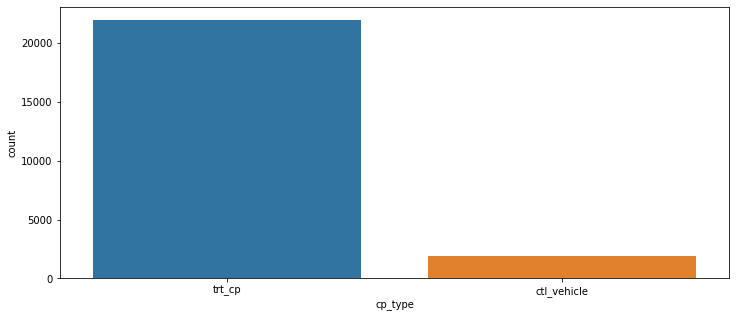

In [18]:
countplot1("cp_type")

cp_type is highly imbalance with 92% of the training set with cp_type as trt_cp

 count of 48 is: 8250
 count of 72 is: 7792
 count of 24 is: 7772


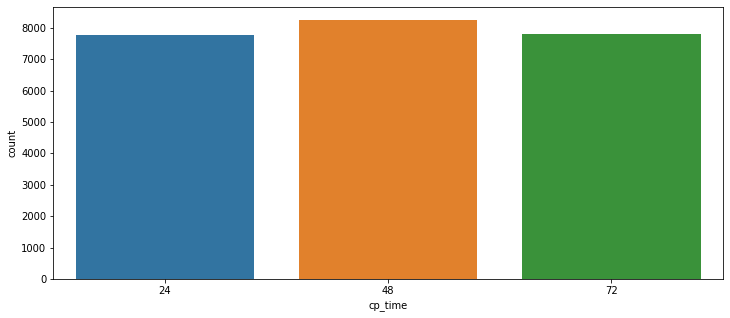

In [19]:
countplot1("cp_time")

Treatment duration is fairly balanced between 24, 48, and 72 hrs.

 count of D1 is: 12147
 count of D2 is: 11667


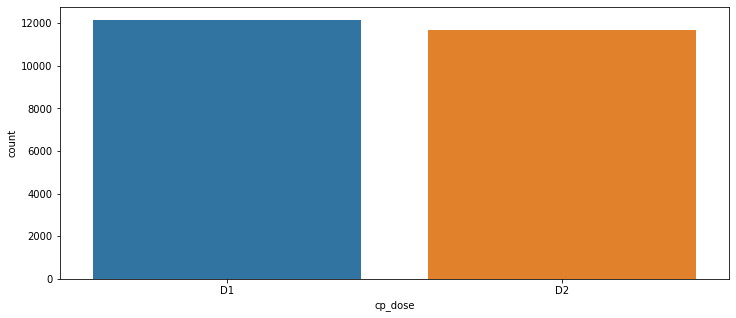

In [21]:
countplot1("cp_dose")

Similiarly cp_dose is balanced as well

### Gene expression features

These are features labelled from "g-0" to "g-771". Let's look at the densities for the first couple of features as an example.

In [24]:
def distribution1(feature, color):
    plt.figure(figsize=(12, 5)).gca()
    sns.distplot(train[feature], color = color)

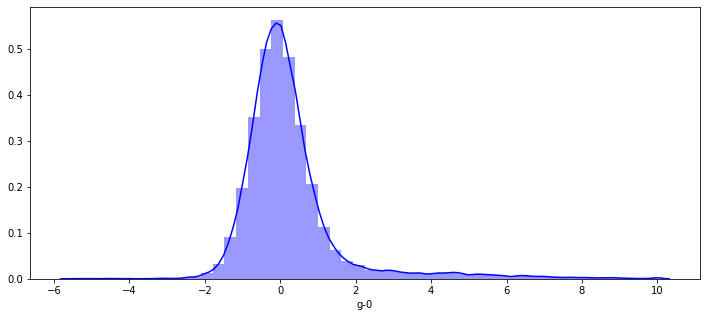

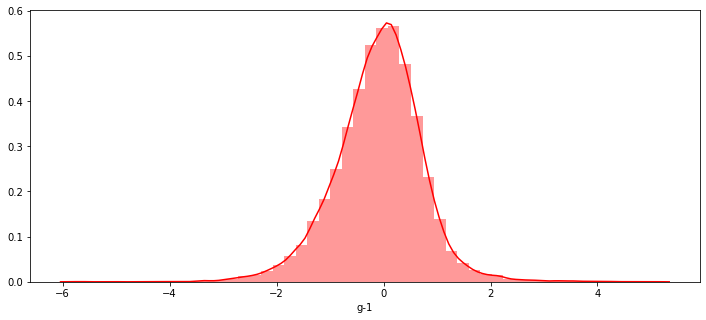

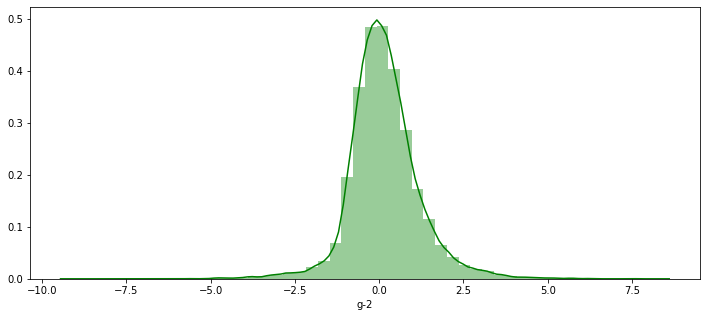

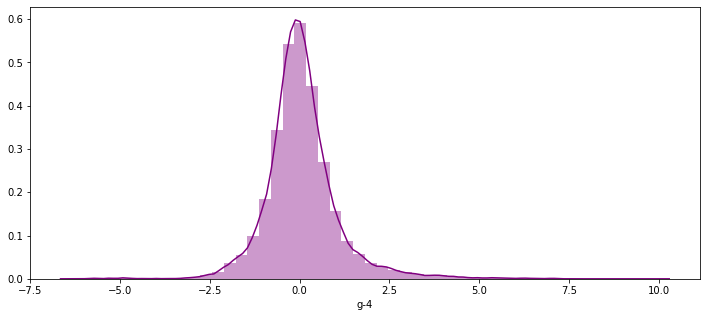

In [30]:
distribution1("g-0","blue")
distribution1("g-1","red")
distribution1("g-2","green")
distribution1("g-4","purple")

These distributions look fairly normal.

### Cell viability features

Similiar to the gene features, the cell viability features are anonymous, labelled from "c-0" to "c-99". Again, let's look at the densities for the first couple of features as an example.

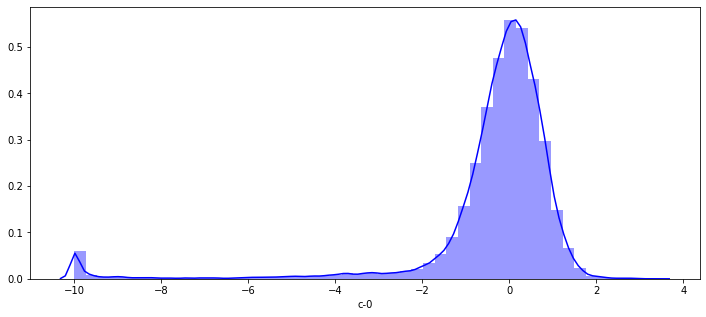

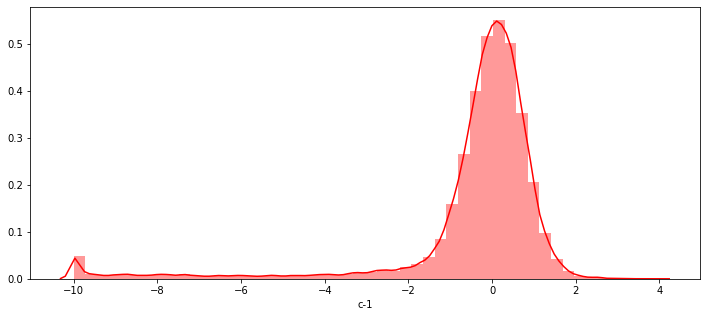

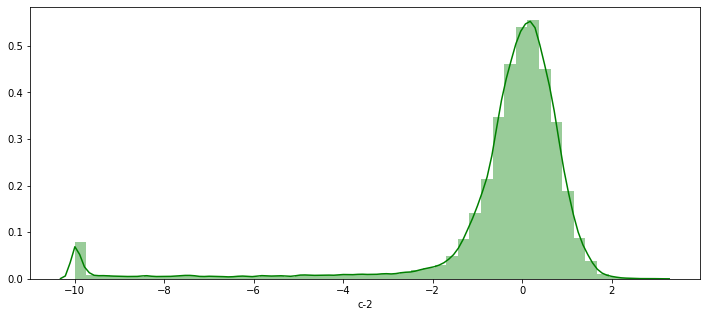

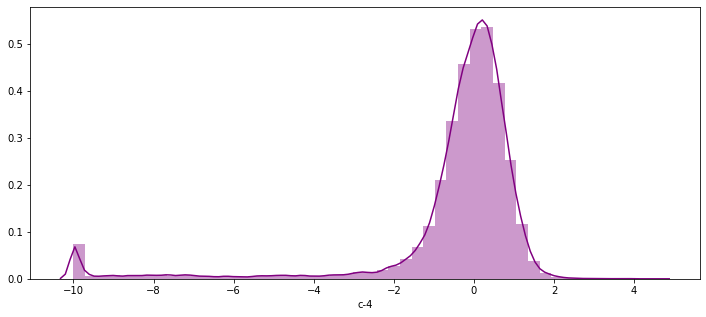

In [31]:
distribution1("c-0","blue")
distribution1("c-1","red")
distribution1("c-2","green")
distribution1("c-4","purple")

Distribution of cell viability is fairly normal except for bumps around -10. Those left tails look significant. This should be considered when preprocessing.

### Targets

The targets are binary columns, indicating whether a certain cell type responds to a drug or not. One drug sample (i.e. a single row) can have multiple activations. Let's look at how many target can be active at once.

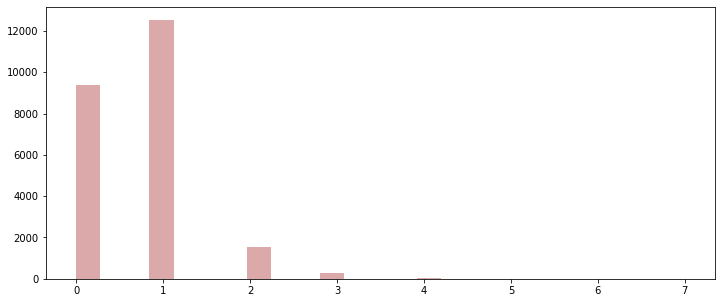

In [48]:
plt.figure(figsize=(12, 5)).gca()
sns.distplot(train_target.sum(axis = 1), kde=False, color = "brown", bins=25)

A few things to note:
- About 10,000 training samples have target of 0 across all 206 receptors, indicating this is a sparse dataset
- The largest cohort (~12,000) training samples have exactly 1 class 
- The highest numbers of positive responses (receptor as 1) is 7.

Let's look at the data at the class level (summing within each column) to understand which classes have the most/least instances of MoA.

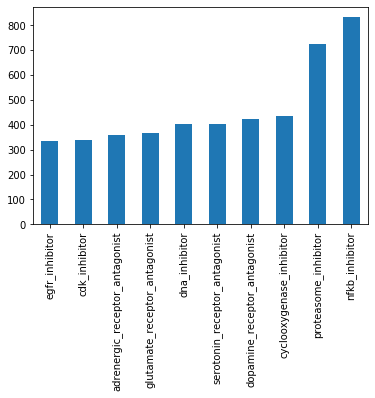

In [59]:
#top 10 classes
top_10_classes = train_target.iloc[:,1:].sum(axis=0).sort_values(ascending=True)[-10:]
top_10_classes.plot.bar(x=top_10_classes.values, y=top_10_classes.index)